In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import mpl
import statsmodels.api as sm
mpl.rcParams['font.sans-serif']=['FangSong']
mpl.rcParams['axes.unicode_minus']=False
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')

## 1. 投资组合管理

### 1.1 数据导入

In [2]:
data = pd.read_csv('C:/Users/jay/asset portfolio.csv', index_col=0)

In [3]:
import datetime
data.index = pd.to_datetime(data.index) # 转换 index 格式
data_stocks = data.drop(['^GSPC'], axis=1) # 先去除 S&P500 列，用于方便后期计算投资组合收益率

In [4]:
data_stocks.head()

,AAPL,JPM,AMZN,GOOGL,NSRGY
Date,,,,,
2022-01-03,178.879929,146.995819,170.404495,144.301590,129.724762
2022-01-04,176.609634,152.568390,167.522003,143.712433,130.075028
2022-01-05,171.911865,149.779129,164.356995,137.119446,125.632278
2022-01-06,169.042068,151.370377,163.253998,137.092072,125.447929
2022-01-07,169.209137,152.870193,162.554001,136.365067,124.719757


<Axes: xlabel='Date'>

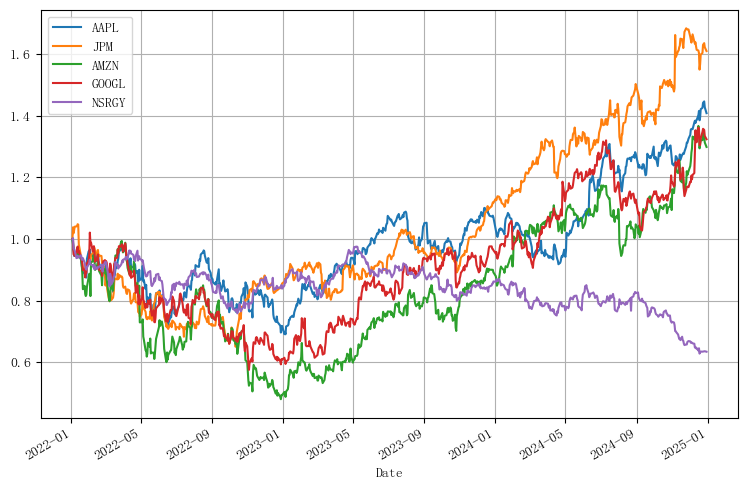

In [5]:
# 将股价按照首个交易日进行归一化处理，并可视化
(data_stocks/data_stocks.iloc[0]).plot(figsize=(9,6), grid=True)

array([[<Axes: title={'center': 'AAPL'}>,
        <Axes: title={'center': 'JPM'}>],
       [<Axes: title={'center': 'AMZN'}>,
        <Axes: title={'center': 'GOOGL'}>],
       [<Axes: title={'center': 'NSRGY'}>, <Axes: >]], dtype=object)

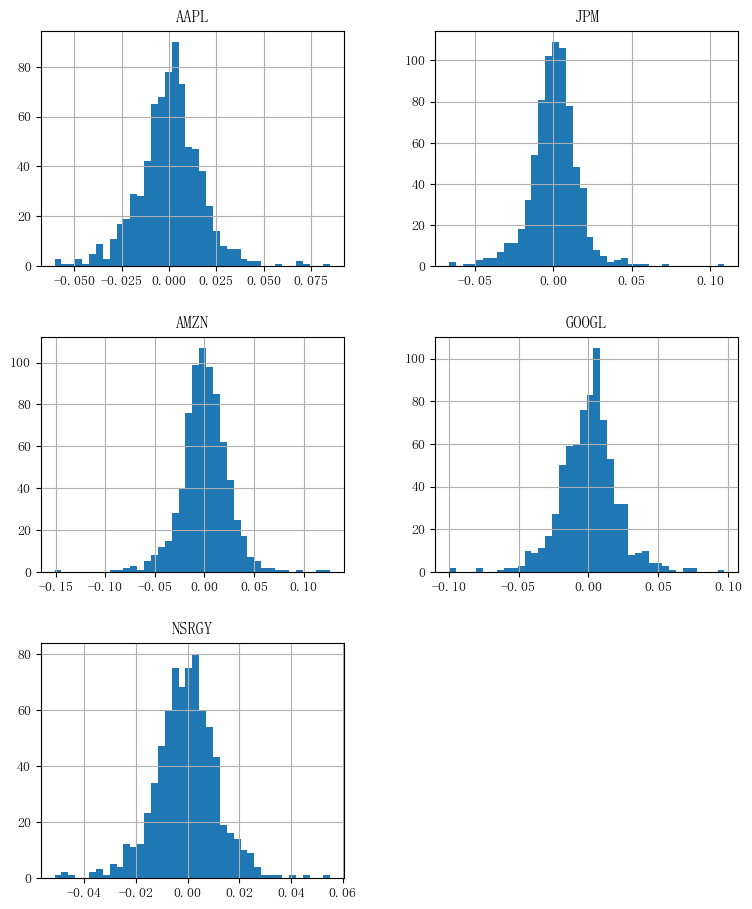

In [6]:
# 计算股票对数收益率,并用直方图显示
R = np.log(data_stocks/data_stocks.shift(1))
R = R.dropna()
R.hist(bins=40, figsize=(9,11))

In [7]:
R.head()

,AAPL,JPM,AMZN,GOOGL,NSRGY
Date,,,,,
2022-01-04,-0.012773,0.037209,-0.017060,-0.004091,0.002696
2022-01-05,-0.026960,-0.018451,-0.019074,-0.046962,-0.034752
2022-01-06,-0.016834,0.010568,-0.006734,-0.000200,-0.001468
2022-01-07,0.000988,0.009859,-0.004297,-0.005317,-0.005821
2022-01-10,0.000116,0.000956,-0.006592,0.011988,-0.024767


In [8]:
R_mean = R.mean()*252 # 计算股票的年化平均收益率
R_vol = R.std()*np.sqrt(252) # 计算股票年化波动率
R_cov = R.cov()*252  # 计算股票协方差矩阵（年化）
R_corr = R.corr()  # 计算股票的相关系数

In [9]:
# 股票间的相关性不是很高，整个组合的分散化效果较好
print(R_corr)

           AAPL       JPM      AMZN     GOOGL     NSRGY
AAPL   1.000000  0.351885  0.565609  0.623614  0.272024
JPM    0.351885  1.000000  0.351190  0.323798  0.231476
AMZN   0.565609  0.351190  1.000000  0.652217  0.170432
GOOGL  0.623614  0.323798  0.652217  1.000000  0.208161
NSRGY  0.272024  0.231476  0.170432  0.208161  1.000000


In [10]:
# 假设5只股票的权重平均分配，计算整个投资组合的收益率和波动率
n = 5
w = np.ones(n)/n #每只股票分配相同的权重

In [11]:
R_portfolio = np.sum(w * R_mean)
vol_portfolio = np.sqrt(np.dot(w, np.dot(R_cov, w.T)))

In [12]:
print('投资组合的年化收益率', round(R_portfolio, 4))
print('投资组合的年化波动率', round(vol_portfolio, 4))

投资组合的年化收益率 0.0607
投资组合的年化波动率 0.2085


### 1.2 投资组合的有效前沿

In [13]:
# 绘制可行集
I = 2000 #创建初始权重的数量
Rp_list = np.ones(I)
Vp_list = np.ones(I)

In [14]:
for i in np.arange(I):
    x = np.random.rand(n) #从均匀分布中随机抽取 0-1 的5个随机数
    weights = x/sum(x) #创建股票的权重
    Rp_list[i] = np.sum(weights*R_mean) #计算投资组合的预期收益率（年化）
    Vp_list[i] = np.sqrt(np.dot(weights, np.dot(R_cov, weights.T))) #计算投资组合的波动率（年化） 

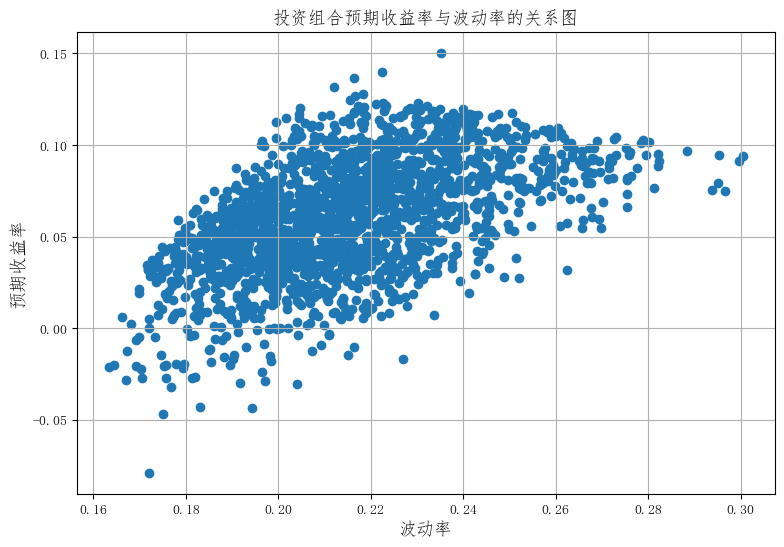

In [15]:
plt.figure(figsize=(9, 6))
plt.scatter(Vp_list, Rp_list)
plt.xlabel(u'波动率', fontsize=13)
plt.ylabel(u'预期收益率', fontsize=13)
plt.title(u'投资组合预期收益率与波动率的关系图', fontsize=13)
plt.grid()
plt.show()

In [16]:
import scipy.optimize as sco

In [17]:
# 计算投资组合波动率的最小值，及其对应的预期收益率和股票的权重
# 定义一个求最优值的函数
def f(w): 
    w = np.array(w)
    Rp_opt = np.sum(w*R_mean)
    Vp_opt = np.sqrt(np.dot(w, np.dot(R_cov, w.T)))
    return np.array([Rp_opt, Vp_opt])
    
# 定义一个计算最小波动率对应权重的函数
def Vmin_f(w):
    return f(w)[1] #输出结果是投资组合的波动率

In [18]:
# 创建权重的边界条件
bnds = ((0,1), (0,1), (0,1), (0,1), (0,1))

# 设立权重的初始值
w0 = ([0.2, 0.2, 0.2, 0.2, 0.2])

In [19]:
cons_vmin = ({'type':'eq', 'fun':lambda x: np.sum(x)-1}) #设置计算波动率最小值的约束条件
result_vmin = sco.minimize(fun=Vmin_f, x0=w0, method='SLSQP', bounds=bnds, constraints=cons_vmin)

In [20]:
result_vmin

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.16152068193134078
       x: [ 1.329e-01  2.483e-01  0.000e+00  4.405e-02  5.748e-01]
     nit: 9
     jac: [ 1.618e-01  1.615e-01  1.667e-01  1.618e-01  1.615e-01]
    nfev: 54
    njev: 9

In [21]:
# 计算全局波动率最小值
Vp_vmin = result_vmin['fun']
print('在可行集上属于全局最小值的波动率', round(Vp_vmin, 4))

在可行集上属于全局最小值的波动率 0.1615


In [22]:
# 计算相对应组合的预期收益率
Rp_vmin = np.sum(R_mean * result_vmin['x'])
print('全局最小值的波动率对应投资组合的预期收益率', round(Rp_vmin, 4))

全局最小值的波动率对应投资组合的预期收益率 -0.0287


In [23]:
# 构建有效前沿，并实现可视化
Rp_target = np.linspace(Rp_vmin, 0.16, 200)  #创建投资组合预期收益率数组
Vp_target = [] #创建存放对应波动率的初始空列表

for r in Rp_target:
    cons_new = ({'type':'eq', 'fun':lambda x: np.sum(x)-1},
                {'type':'eq', 'fun':lambda x: f(x)[0]-r})
    result_new = sco.minimize(fun=Vmin_f, x0=w0, method='SLSQP', bounds=bnds,
                              constraints=cons_new)
    Vp_target.append(result_new['fun']) #存放每一次计算得到的波动率

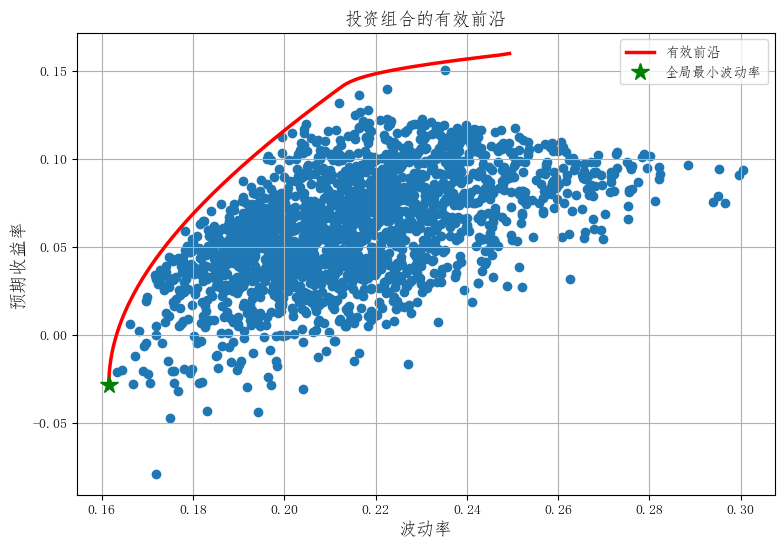

In [24]:
plt.figure(figsize=(9, 6))
plt.scatter(Vp_list, Rp_list)
plt.plot(Vp_target, Rp_target, 'r-', label=u'有效前沿', lw=2.5)
plt.plot(Vp_vmin, Rp_vmin, 'g*', label=u'全局最小波动率', markersize=13)
plt.xlabel(u'波动率', fontsize=13)
plt.ylabel(u'预期收益率', fontsize=13)
plt.title(u'投资组合的有效前沿', fontsize=13)
plt.legend()
plt.grid()
plt.show()

### 1.3 绘制资本市场线

In [25]:
Rf = 0.015 #假设1年期无风险收益率为0.02
def F(w):
    w = np.array(w)
    Rp_opt = np.sum(w*R_mean)
    Vp_opt = np.sqrt(np.dot(w, np.dot(R_cov, w.T)))
    Slope = (Rp_opt - Rf)/Vp_opt  #计算资本市场线的斜率
    return np.array([Rp_opt, Vp_opt, Slope])

def Slope_F(w):
    return -F(w)[-1]   #优化模型只能优化最小值，所以输出结果是负的资本市场线斜率

In [26]:
cons_Slope = ({'type':'eq', 'fun':lambda x: np.sum(x)-1}) #权重约束条件

In [27]:
result_Slope = sco.minimize(fun=Slope_F, x0=w0, method='SLSQP', bounds=bnds, constraints=cons_Slope)

In [28]:
result_Slope

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.6066982889462261
       x: [ 2.523e-01  7.477e-01  0.000e+00  0.000e+00  1.561e-17]
     nit: 5
     jac: [-6.806e-02 -6.824e-02  1.021e-01 -4.821e-03  8.422e-01]
    nfev: 30
    njev: 5

In [29]:
# 计算资本市场的斜率
Slope = -result_Slope['fun']
print('资本市场线的斜率', round(Slope,4))

资本市场线的斜率 0.6067


In [30]:
# 市场组合的每只股票配置权重
Wm = result_Slope['x']
print('市场组合配置的苹果公司的权重', round(Wm[0],4))
print('市场组合配置的JP摩根的权重', round(Wm[1],4))
print('市场组合配置的亚马逊的权重', round(Wm[2],4))
print('市场组合配置的谷歌的权重', round(Wm[3],4))
print('市场组合配置的雀巢的权重', round(Wm[-1],4))

市场组合配置的苹果公司的权重 0.2523
市场组合配置的JP摩根的权重 0.7477
市场组合配置的亚马逊的权重 0.0
市场组合配置的谷歌的权重 0.0
市场组合配置的雀巢的权重 0.0


In [31]:
Rm = np.sum(R_mean*Wm)
Vm = (Rm - Rf)/Slope

In [32]:
print('市场组合的预期收益率', round(Rm,4))
print('市场组合的波动率',round(Vm, 4))

市场组合的预期收益率 0.1484
市场组合的波动率 0.2199


In [33]:
# 资本市场线可视化
Rp_CML = np.linspace(Rf, 0.15, 200)
Vp_CML = (Rp_CML - Rf)/Slope

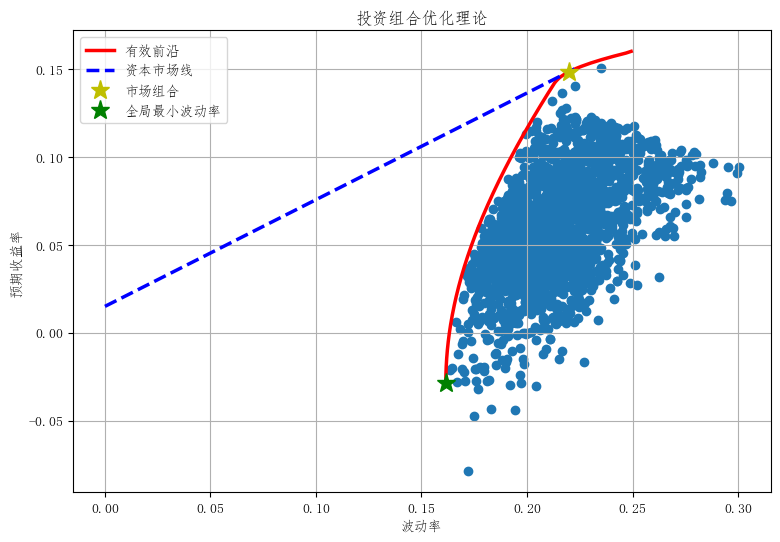

In [34]:
plt.figure(figsize=(9,6))
plt.scatter(Vp_list, Rp_list)
plt.plot(Vp_target, Rp_target, 'r-', label=u'有效前沿', lw=2.5)
plt.plot(Vp_CML, Rp_CML, 'b--', label=u'资本市场线', lw=2.5)
plt.plot(Vm, Rm, 'y*', label=u'市场组合', markersize=14)
plt.plot(Vp_vmin, Rp_vmin, 'g*', label=u'全局最小波动率', markersize=14)
plt.xlabel(u'波动率')
plt.ylabel(u'预期收益率')
plt.title(u'投资组合优化理论')
plt.legend()
plt.grid()
plt.show()

### 1.4 投资组合绩效评估

In [35]:
# 假设无风险收益率为 0.015
rf = 0.015

#### 1.4.1 (Sharp Ratio, SR)

**夏普比率（Sharpe Ratio）概述**

**夏普比率**是金融领域用于衡量投资风险调整后回报的一个重要指标。由诺贝尔经济学奖得主威廉·夏普（William F. Sharpe）提出，通常用于评估一个投资组合的表现。

其计算公式为：

$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$

其中：
- $R_p$：投资组合的年化收益率（或单个资产的年化收益率）。
- $R_f$：无风险收益率（如国债收益率）。
- $\sigma_p$：投资组合（或单个资产）的年化标准差（波动率）。


In [36]:
def SR(Rp, Rf, Vp):
    sharp_ratio = (Rp - Rf)/Vp
    return sharp_ratio

In [37]:
SR_3years = SR(Rp=R_mean, Rf=rf, Vp=R_vol)
print('2022-2024年3年平均的Sharp ration\n', round(SR_3years, 4))

2022-2024年3年平均的Sharp ration
 AAPL     0.3691
JPM      0.5806
AMZN     0.1895
GOOGL    0.2414
NSRGY   -0.8797
dtype: float64


#### 1.4.2 (Sortino Ratio, SOR)

**Sortino比率（Sortino Ratio）概述**

**Sortino比率**是衡量投资风险调整后回报的一个重要指标，它是对夏普比率的改进。与夏普比率不同，Sortino比率只考虑下行风险（即亏损的风险），而忽略了正向波动性。因此，Sortino比率更能反映投资者关心的亏损风险。

其计算公式为：

$$
\text{Sortino Ratio} = \frac{R_p - R_f}{\sigma_d}
$$

其中：
- $R_p$：投资组合的年化收益率（或单个资产的年化收益率）。
- $R_f$：无风险收益率（如国债收益率）。
- $\sigma_d$：投资组合的下行标准差（只考虑负回报的波动性）。

**注意：**下行标准差（$\sigma_d$）是仅基于负回报计算的标准差，通常比整体的波动性低，因此Sortino比率比夏普比率更能反映出实际的风险调整回报。


In [38]:
def SOR(Rp, Rf, Vd):
    sortino_ratio = (Rp - Rf)/Vd
    return sortino_ratio

In [39]:
V_down = np.zeros_like(R_mean) #创建放置股票收益率下行标准差的初始数组
for i in range(len(V_down)):
    R_neg = R.iloc[:,i][R.iloc[:,i]<0]
    N_down = len(R_neg)
    V_down[i] = np.sqrt(252)*np.sqrt(np.sum(R_neg**2)/N_down) #计算年化下行标准差
    print(R.columns[i], '年化下行标准差', round(V_down[i], 4))

AAPL 年化下行标准差 0.2762
JPM 年化下行标准差 0.2526
AMZN 年化下行标准差 0.3909
GOOGL 年化下行标准差 0.3395
NSRGY 年化下行标准差 0.1999


In [40]:
SOR_3years = SOR(Rp=R_mean, Rf=rf, Vd=V_down)
print('2022-2024年3年平均的索提诺比率\n', round(SOR_3years, 4))

2022-2024年3年平均的索提诺比率
 AAPL     0.3616
JPM      0.5730
AMZN     0.1860
GOOGL    0.2330
NSRGY   -0.8391
dtype: float64


#### 1.4.3 (Treynor Ratio, TR)

**Treynor比率（Treynor Ratio）概述**

**Treynor比率**是衡量投资组合每单位系统性风险（由β衡量）所获得超额回报的指标。由经济学家 Jack Treynor 提出，它与夏普比率类似，但使用 **β**（即相对于市场的系统性风险）来代替标准差，因此适用于 **已实现分散化的投资组合**。

其计算公式为：

$$
\text{Treynor Ratio} = \frac{R_p - R_f}{\beta_p}
$$

其中：

- $R_p$：投资组合的年化收益率（或单个资产的年化收益率）  
- $R_f$：无风险收益率（如国债收益率）  
- $\beta_p$：投资组合的β值，衡量相对于市场的系统性风险  

**注意：**Treynor比率假设非系统性风险已被多样化，因此更适用于投资基金或ETF等广泛分散的投资组合，而非单一资产。

In [41]:
# 定义一个计算 TR 的函数
def TR(Rp, Rf, beta):
    treynor_ratio = (Rp - Rf)/beta
    return treynor_ratio

In [42]:
s_p500 = data[['^GSPC']]

In [43]:
s_p500 = np.log(s_p500/s_p500.shift(1))
s_p500 = s_p500.dropna()

In [44]:
X_addcons = sm.add_constant(s_p500) #添加一列常数列，方便后续拟合线性回归模型

In [45]:
betas = np.zeros_like(R_mean) #创建一个放置贝塔值的初始数组
cons = np.zeros_like(R_mean) #创建一个放置方程常数项的初始数组

In [46]:
for i in range(len(R_mean)):
    Y = R.iloc[:,i]
    model = sm.OLS(endog=Y, exog=X_addcons)
    result = model.fit()
    cons[i] = result.params[0]
    betas[i] = result.params[1]
    print(R.columns[i], '贝塔值', round(betas[i], 4))

AAPL 贝塔值 1.2089
JPM 贝塔值 0.8644
AMZN 贝塔值 1.6129
GOOGL 贝塔值 1.3349
NSRGY 贝塔值 0.3861


In [47]:
X_list = np.linspace(np.min(s_p500), np.max(s_p500), 200) #创建对应x轴的数组

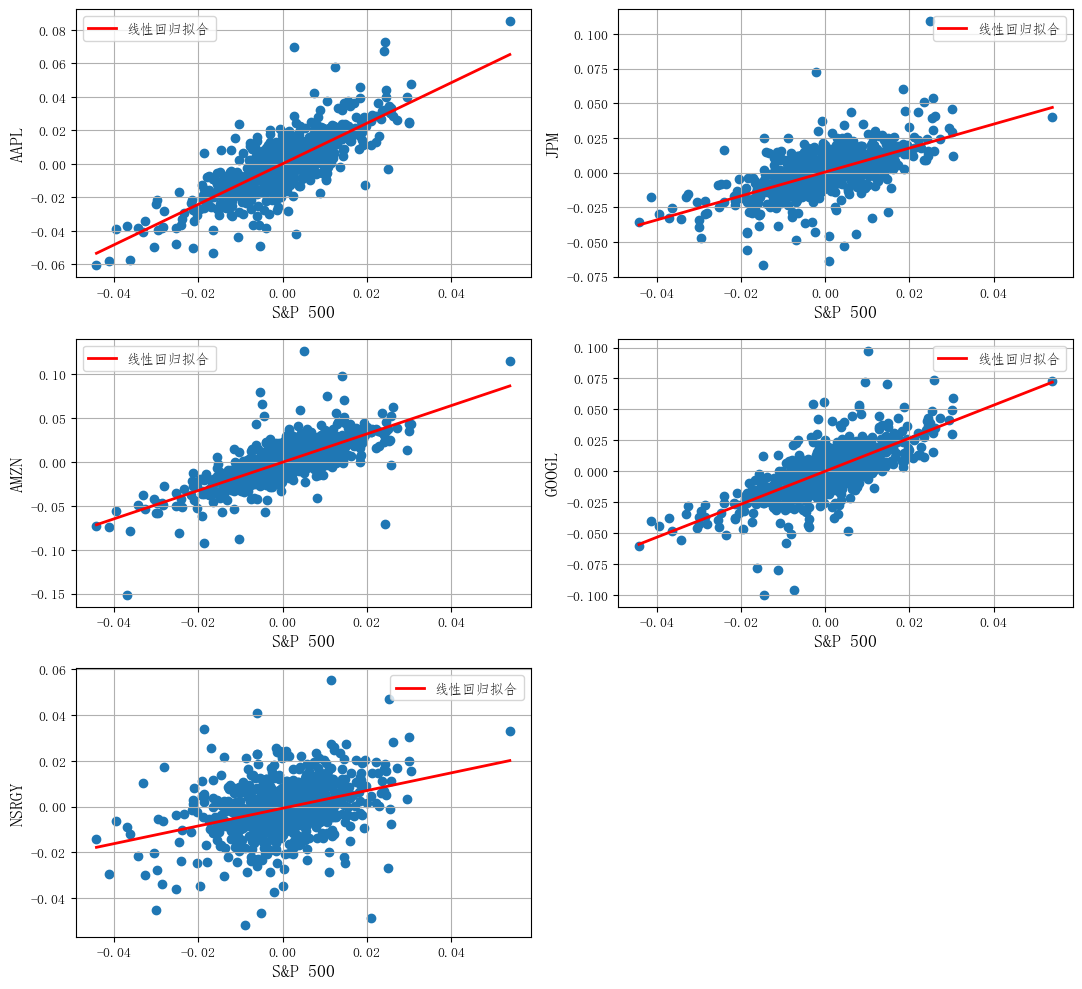

In [48]:
plt.figure(figsize=(11,10))
for i in range(len(R_mean)):
    plt.subplot(3, 2, i+1)
    plt.scatter(s_p500, R.iloc[:,i])
    plt.plot(X_list, cons[i] + betas[i]*X_list, 'r-', label=u'线性回归拟合', lw=2.0)
    plt.xlabel('S&P 500', fontsize=13)
    plt.ylabel(R.columns[i], fontsize=13)
    plt.legend()
    plt.grid()
plt.tight_layout()  # 避免子图重叠
plt.show()          # 放在循环外，一次性展示所有子图

In [49]:
TR_3years = TR(Rp=R_mean, Rf=rf, beta=betas)
print('2022-2024年3年平均的特雷诺比率\n', round(TR_3years, 4))

2022-2024年3年平均的特雷诺比率
 AAPL     0.0826
JPM      0.1675
AMZN     0.0451
GOOGL    0.0593
NSRGY   -0.4345
dtype: float64


### 1.5 业绩归因

In [50]:
R_mean.values

array([ 0.11489615,  0.15975843,  0.08769475,  0.09411333, -0.15277272])

In [51]:
# 为方便演示，我们对资产组合的收益和权重进行假设
data = {
    'Sector': ['Tech', 'Finance', 'Consumer Discretionary', 'Communication','Consumer Staples'],
    'Benchmark_Weight': [0.2, 0.2, 0.2, 0.2, 0.2],          # 基准权重
    'Benchmark_Return': [0.08, 0.04, 0.03, 0.05, 0.03],     # 基准收益
    'Portfolio_Weight': [0.3, 0.35, 0.18, 0.12, 0.05],      # 实际权重
    'Portfolio_Return': [ 0.11489615,  0.15975843,  0.08769475,  0.09411333, -0.15277272]  # 实际收益
}

In [52]:
data = pd.DataFrame(data)

In [53]:
data

,Sector,Benchmark_Weight,Benchmark_Return,Portfolio_Weight,Portfolio_Return
0,Tech,0.2,0.08,0.30,0.114896
1,Finance,0.2,0.04,0.35,0.159758
2,Consumer Discretionary,0.2,0.03,0.18,0.087695
3,Communication,0.2,0.05,0.12,0.094113
4,Consumer Staples,0.2,0.03,0.05,-0.152773


In [54]:
# 总体基准收益
R_b = (data['Benchmark_Weight'] * data['Benchmark_Return']).sum()
# 配置效应（投资组合权重 与 基准收益 差异）
data['Allocation_Effect'] = (data['Portfolio_Weight'] - data['Benchmark_Weight']) * (data['Benchmark_Return'] - R_b)
# 选股效应（投资组合收益 与 基准收益 差异）
data['Selection_Effect'] = data['Benchmark_Weight'] * (data['Portfolio_Return'] - data['Benchmark_Return'])
# 交互效应（交叉影响）
data['Interaction_Effect'] = (data['Portfolio_Weight'] - data['Benchmark_Weight']) * (data['Portfolio_Return'] - data['Benchmark_Return'])
# 总归因
data['Total_Attribution'] = data['Allocation_Effect'] + data['Selection_Effect'] + data['Interaction_Effect']

In [55]:
# 查看结果
print(data[['Sector', 'Allocation_Effect', 'Selection_Effect', 'Interaction_Effect', 'Total_Attribution']])

                   Sector  Allocation_Effect  Selection_Effect  \
0                    Tech            0.00340          0.006979   
1                 Finance           -0.00090          0.023952   
2  Consumer Discretionary            0.00032          0.011539   
3           Communication           -0.00032          0.008823   
4        Consumer Staples            0.00240         -0.036555   

   Interaction_Effect  Total_Attribution  
0            0.003490           0.013869  
1            0.017964           0.041015  
2           -0.001154           0.010705  
3           -0.003529           0.004974  
4            0.027416          -0.006739  


In [56]:
# 结果验证
portfolio_return = (data['Portfolio_Weight'] * data['Portfolio_Return']).sum()
excess_return = portfolio_return - R_b
print(f"\n组合总超额收益: {excess_return:.4f}")
print(f"归因总和: {data['Total_Attribution'].sum():.4f}")


组合总超额收益: 0.0638
归因总和: 0.0638


## 2. 风险价值测量

### 2.1 风险价值的可视化

In [57]:
import scipy.stats as st

In [58]:
x = 0.95
z = st.norm.ppf(q = 1-x) 
x = np.linspace(-4, 4, 200)
y = st.norm.pdf(x)
x1 = np.linspace(-4, z, 100)
y1 = st.norm.pdf(x1)

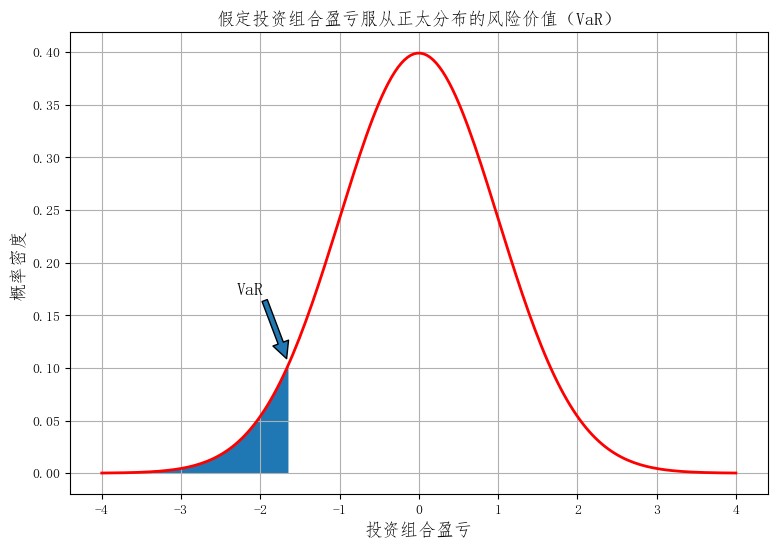

In [59]:
plt.figure(figsize=(9, 6))
plt.plot(x, y, 'r-', lw=2.0)
plt.fill_between(x1, y1)  #颜色填充
plt.xlabel(u'投资组合盈亏', fontsize=13)
plt.ylabel(u'概率密度', fontsize=13)
plt.annotate('VaR', xy=(z-0.02, st.norm.pdf(z)+0.005), xytext=(-2.3,0.17,),
             arrowprops=dict(shrink=0.01), fontsize=13)
plt.title(u'假定投资组合盈亏服从正太分布的风险价值（VaR）', fontsize=13)
plt.grid()
plt.show()

### 2.2 方差-协方差法

In [60]:
# 定义方差-协方差法计算VaR值的函数
def VaR_VCM(Value, Rp, Vp, X, N):
    """ X：代表置信水平
        N: 代表持有期，用天数表示"""
    import scipy.stats as st
    from numpy import sqrt
    z = abs(st.norm.ppf(q = 1-X))
    VaR_1day = Value*(z*Vp-Rp)
    VaR_Nday = sqrt(N)*VaR_1day
    return VaR_Nday

在正态分布假设下，**期望损失（Expected Shortfall, ES）** 的计算公式如下：

$$
ES = \mu - \sigma \cdot \frac{\phi(z)}{1 - \alpha}
$$

其中：

- $\mu$：资产或投资组合的期望收益（例如日收益）
- $\sigma$：投资组合的标准差（波动率）
- $\alpha$：置信水平（例如 0.95 或 0.99）
- $z$：VaR 的分位点，即 $z = \Phi^{-1}(1 - \alpha)$
- $\phi(z)$：标准正态分布在 $z$ 点的概率密度函数值（不是累积分布）

In [61]:
# 定义方差-协方差法计算 Expected Shortfall（ES）的函数
def ES_VCM(Value, Rp, Vp, X, N):
    import scipy.stats as st
    from numpy import sqrt
    z = abs(st.norm.ppf(1 - X))  # Z-score 对应 VaR 水平
    phi = st.norm.pdf(z)         # 标准正态分布的概率密度函数值
    ES_1day = Value * (phi / (1 - X) * Vp - Rp)  # 一日期望损失
    ES_Nday = sqrt(N) * ES_1day                  # N日期望损失
    return ES_Nday

In [62]:
w = np.array([0.3, 0.35, 0.18, 0.12, 0.05]) #假设投资组合中，股票按此权重分配

In [63]:
R_daily = R.mean()
R_daily

AAPL     0.000456
JPM      0.000634
AMZN     0.000348
GOOGL    0.000373
NSRGY   -0.000606
dtype: float64

In [64]:
R_cov = R.cov()
R_cov

,AAPL,JPM,AMZN,GOOGL,NSRGY
AAPL,0.000291,0.000094,0.000233,0.000219,0.000056
JPM,0.000094,0.000247,0.000133,0.000105,0.000044
AMZN,0.000233,0.000133,0.000584,0.000325,0.000049
GOOGL,0.000219,0.000105,0.000325,0.000426,0.000052
NSRGY,0.000056,0.000044,0.000049,0.000052,0.000144


In [65]:
Rp_daily = np.sum(w * R_daily)
print('2022-2024年投资组合的日平均收益率', round(Rp_daily, 6))

2022-2024年投资组合的日平均收益率 0.000436


In [66]:
Vp_daily = np.sqrt(np.dot(w, np.dot(R_cov, w.T))) 
print('2022-2024年投资组合的日波动率', round(Vp_daily, 6))

2022-2024年投资组合的日波动率 0.013673


In [67]:
# 设定初始值
value_port = 1e10
D = 10
X = 0.95

In [68]:
# 持有期为1天，置信水平为95%的VaR值
VaR95_1day_VCM = VaR_VCM(Value=value_port, Rp=Rp_daily, Vp=Vp_daily, X=X, N=1)

# 持有期为1天，置信水平为95%的ES值
ES95_1day_VCM = ES_VCM(Value=value_port, Rp=Rp_daily, Vp=Vp_daily, X=X, N=1)

In [69]:
# 持有期为10天，置信水平为95%的VaR值
VaR95_10day_VCM = VaR_VCM(Value=value_port, Rp=Rp_daily, Vp=Vp_daily, X=X, N=D)

# 持有期为10天，置信水平为95%的ES值
ES95_10day_VCM = ES_VCM(Value=value_port, Rp=Rp_daily, Vp=Vp_daily, X=X, N=D)

In [70]:
print('方差-协方差法计算持有期为10天，置信水平为99%的风险价值VaR', round(VaR95_10day_VCM,2))
print('方差-协方差法计算持有期为10天，置信水平为99%的风险价值ES', round(ES95_10day_VCM,2))

方差-协方差法计算持有期为10天，置信水平为99%的风险价值VaR 697402992.97
方差-协方差法计算持有期为10天，置信水平为99%的风险价值ES 878072557.8


### 2.3 历史模拟法

In [71]:
value_past = value_port * w  #用投资组合的总市值乘分配比例，计算每个股票的最新市值

In [72]:
profit_past = np.dot(R,value_past)  #计算2022-2024年每个交易日投资组合的模拟盈亏金额
profit_past = pd.DataFrame(data=profit_past, index=R.index, columns=['投资组合的模拟日收益'])

In [73]:
profit_past.head()

,投资组合的模拟日收益
Date,
2022-01-04,5.764227e+07
2022-01-05,-2.535223e+08
2022-01-06,-2.660954e+07
2022-01-07,2.044582e+07
2022-01-10,-6.166719e+06


<Axes: xlabel='Date'>

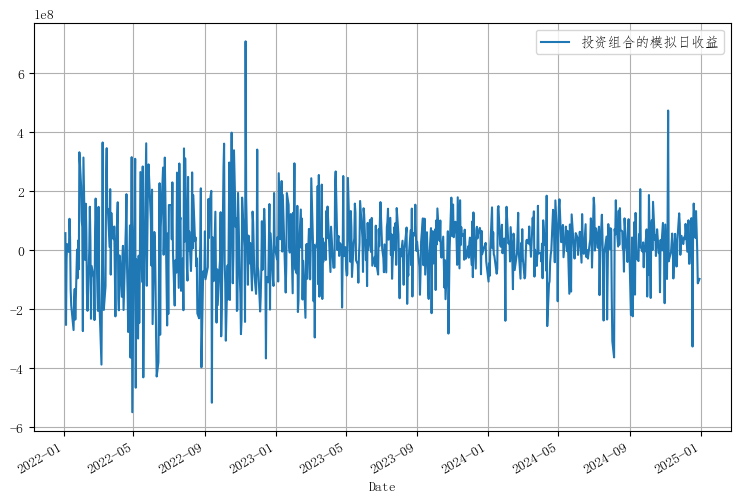

In [74]:
profit_past.plot(figsize=(9, 6), grid=True)

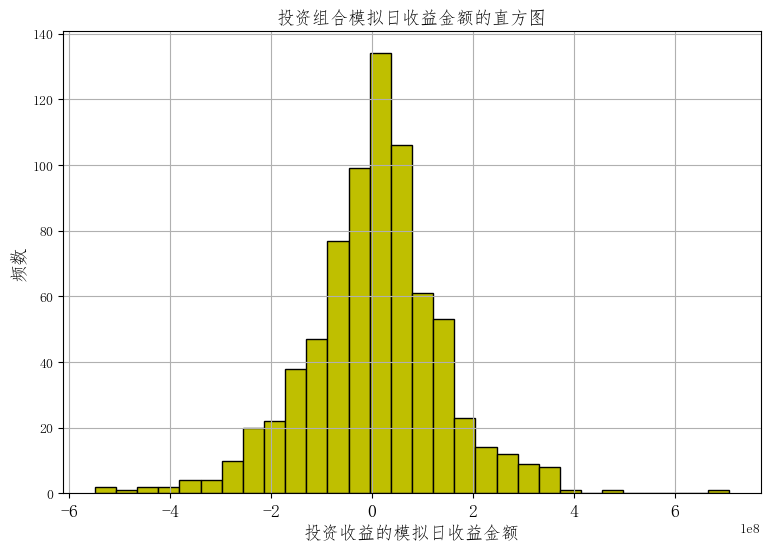

In [75]:
#用直方图简单查看，模拟日收益是否符合正太分布(呈现左偏、肥尾现象）
plt.figure(figsize=(9,6))
plt.hist(np.array(profit_past), bins=30, facecolor='y', edgecolor='k')
plt.xticks(fontsize=13)
plt.xlabel(u'投资收益的模拟日收益金额', fontsize=13)
plt.ylabel(u'频数', fontsize=13)
plt.title(u'投资组合模拟日收益金额的直方图', fontsize=13)
plt.grid()
plt.show()

In [76]:
# 用历史模拟法计算，持有期为1天，置信水平为95%的风险价值
VaR95_1day_history = np.abs(profit_past.quantile(q = 1-X))
ES95_1day_history = np.abs(profit_past[profit_past <= 
                           profit_past.quantile(q = 1-X)].mean())
VaR95_1day_history = float(VaR95_1day_history)
ES95_1day_history = float(ES95_1day_history)

In [77]:
# 用历史模拟法计算，持有期为10天，置信水平为95%的风险价值
VaR95_10day_history = np.sqrt(D) * VaR95_1day_history
ES95_10day_history = np.sqrt(D) * ES95_1day_history
print('历史模拟法计算持有期为10天，置信水平为95%的风险价值VaR', round(VaR95_10day_history,2))
print('历史模拟法计算持有期为10天，置信水平为95%的风险价值ES', round(ES95_10day_history,2))

历史模拟法计算持有期为10天，置信水平为95%的风险价值VaR 733037434.97
历史模拟法计算持有期为10天，置信水平为95%的风险价值ES 987009503.85


### 2.4 蒙特卡罗模拟法

#### 2.4.1 学生t分布

In [78]:
import numpy.random as npr #导入Numpy的子模块random
I = 100000 #模拟次数
n = 8 #学生t分布的自由度(参考国外的研究发现，金融资产的收益率服从学生t分布时，自由度估值通常处于[4,8]区间
epsilon = npr.standard_t(df=n, size=I) #从学生t分布进行抽样

In [79]:
data_stocks.tail()

,AAPL,JPM,AMZN,GOOGL,NSRGY
Date,,,,,
2024-12-23,254.989655,235.713257,225.059998,194.406113,82.300003
2024-12-24,257.916443,239.589233,229.050003,195.884399,82.349998
2024-12-26,258.735504,240.409912,227.050003,195.375000,82.480003
2024-12-27,255.309296,238.462036,223.750000,192.538254,82.480003
2024-12-30,251.923019,236.632812,221.300003,191.020004,82.279999


In [80]:
p1 = data_stocks.iloc[-1, 0] #投资组合中，第一个资产（苹果公司）的最新收盘价
p2 = data_stocks.iloc[-1, 1] #投资组合中，第二个资产（JP摩根）的最新收盘价
p3 = data_stocks.iloc[-1, 2]
p4 = data_stocks.iloc[-1, 3]
p5 = data_stocks.iloc[-1, -1]

In [81]:
R_mean = R.mean()*252 #每只股票的年化平均收益率
R_vol = R.std()*np.sqrt(252) #每只股票的年化波动率
dt = 1/252 #设定步长为1个交易日

**几何布朗运动的 Euler 离散法**

**差分公式：**

$$
S_{t+\Delta t} = S_t \cdot \exp\left[ \left( \mu - \frac{1}{2} \sigma^2 \right)\Delta t + \sigma \sqrt{\Delta t} \cdot Z \right]
$$

---

**参数说明：**

| 参数         | 含义                                                                 |
|--------------|----------------------------------------------------------------------|
| $S_t$        | 当前时间 $t$ 的资产价格                                              |
| $\Delta t$   | 时间步长（例如：日频数据 $\Delta t = \frac{1}{252}$，表示一年252个交易日） |
| $\mu$        | 资产的预期收益率（年化）                                             |
| $\sigma$     | 资产的波动率（年化）                                                 |
| $Z$          | 随机扰动项，通常为**标准正态分布 $\mathcal{N}(0,1)$**，也可采用**学生t分布**以模拟厚尾风险 |

In [82]:
# 通过差分公示预测各只股票下一个交易日的收盘价
p1_new = p1 * np.exp((R_mean[0] - 0.5*R_vol[0]**2) * dt + R_vol[0]*epsilon*np.sqrt(dt))
p2_new = p2 * np.exp((R_mean[1] - 0.5*R_vol[1]**2) * dt + R_vol[1]*epsilon*np.sqrt(dt))
p3_new = p3 * np.exp((R_mean[2] - 0.5*R_vol[2]**2) * dt + R_vol[2]*epsilon*np.sqrt(dt))
p4_new = p4 * np.exp((R_mean[3] - 0.5*R_vol[3]**2) * dt + R_vol[3]*epsilon*np.sqrt(dt))
p5_new = p5 * np.exp((R_mean[4] - 0.5*R_vol[4]**2) * dt + R_vol[4]*epsilon*np.sqrt(dt))

In [83]:
# 模拟投资组合中各只股票下一个交易日的收益
profit1 = (p1_new/p1 - 1) * value_port * w[0]
profit2 = (p2_new/p2 - 1) * value_port * w[1]
profit3 = (p3_new/p3 - 1) * value_port * w[2]
profit4 = (p4_new/p4 - 1) * value_port * w[3]
profit5 = (p5_new/p5 - 1) * value_port * w[4]

In [84]:
profit_port = profit1 + profit2 + profit3 + profit4 + profit5 #整个投资组合下一个交易日的收益

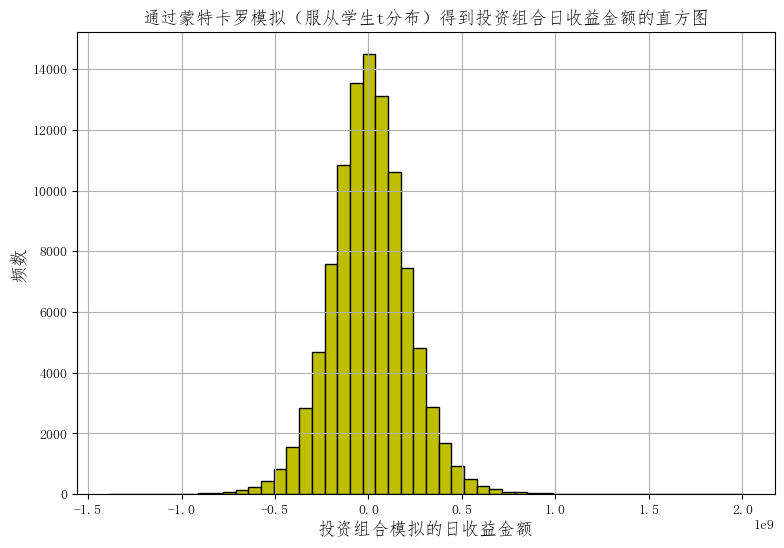

In [85]:
plt.figure(figsize=(9,6))
plt.hist(profit_port, bins=50, facecolor='y', edgecolor='k')
plt.xlabel(u'投资组合模拟的日收益金额', fontsize=13)
plt.ylabel(u'频数', fontsize=13)
plt.title(u'通过蒙特卡罗模拟（服从学生t分布）得到投资组合日收益金额的直方图', fontsize=13)
plt.grid()
plt.show()

In [86]:
# 用蒙特卡罗模拟法计算，持有期为1天，置信水平为95%的风险价值
VaR95_1day_MC = np.abs(np.percentile(a=profit_port, q=(1-X)*100))
ES95_1day_MC = np.abs(profit_port[profit_port <= np.percentile
                      (profit_port, q=(1-X)*100)].mean())

In [87]:
VaR95_10day_MC = np.sqrt(D) * VaR95_1day_MC
ES95_10day_MC = np.sqrt(D) * ES95_1day_MC
print('蒙特卡罗法（t分布）计算持有期为10天，置信水平为95%的风险价值VaR', round(VaR95_10day_MC,2))
print('蒙特卡罗法（t分布）计算持有期为10天，置信水平为95%的风险价值ES', round(ES95_10day_MC,2))

蒙特卡罗法（t分布）计算持有期为10天，置信水平为95%的风险价值VaR 1038304169.45
蒙特卡罗法（t分布）计算持有期为10天，置信水平为95%的风险价值ES 1388918045.79


#### 2.4.2 正态分布

In [88]:
data_stocks.tail()

,AAPL,JPM,AMZN,GOOGL,NSRGY
Date,,,,,
2024-12-23,254.989655,235.713257,225.059998,194.406113,82.300003
2024-12-24,257.916443,239.589233,229.050003,195.884399,82.349998
2024-12-26,258.735504,240.409912,227.050003,195.375000,82.480003
2024-12-27,255.309296,238.462036,223.750000,192.538254,82.480003
2024-12-30,251.923019,236.632812,221.300003,191.020004,82.279999


In [89]:
P = np.array(data_stocks.iloc[-1]) #单个股票的最新收盘价（数组格式）

In [90]:
epsilon_norm = npr.standard_normal(I) #从正太分布中取样

In [91]:
P_new = np.zeros(shape = (I, len(R_mean))) #用于存放模拟价格的初始数组

In [92]:
# 模拟每只股票下一个交易日的价格
for i in range(len(R_mean)):
    P_new[:,i] = P[i] * np.exp((R_mean[i] - 0.5*R_vol[i]**2)*dt + 
                               R_vol[i] * epsilon_norm * np.sqrt(dt))

In [93]:
profit_port_norm = (np.dot(P_new/P - 1, w)) * value_port

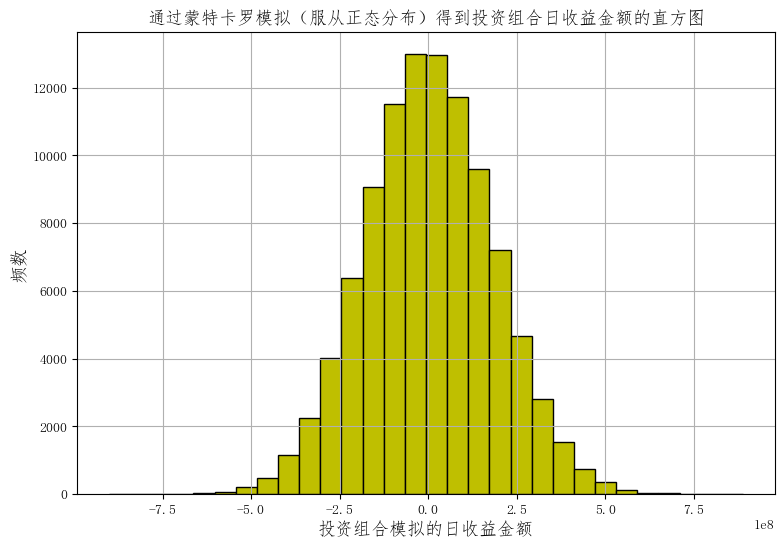

In [94]:
plt.figure(figsize=(9,6))
plt.hist(profit_port_norm, bins=30, facecolor='y', edgecolor='k')
plt.xlabel(u'投资组合模拟的日收益金额', fontsize=13)
plt.ylabel(u'频数', fontsize=13)
plt.title(u'通过蒙特卡罗模拟（服从正态分布）得到投资组合日收益金额的直方图', fontsize=13)
plt.grid()
plt.show()

In [95]:
# 用蒙特卡罗模拟法(正态分布）计算，持有期为1天，置信水平为95%的风险价值
VaR95_1day_MC_norm = np.abs(np.percentile(a=profit_port_norm, q=(1-X)*100))
ES95_1day_MC_norm = np.abs(profit_port_norm[profit_port_norm <= np.percentile
                      (profit_port_norm, q=(1-X)*100)].mean())

In [96]:
VaR95_10day_MC_norm = np.sqrt(D) * VaR95_1day_MC_norm
ES95_10day_MC_norm = np.sqrt(D) * ES95_1day_MC_norm
print('蒙特卡罗法（正态分布）计算持有期为10天，置信水平为95%的风险价值VaR', round(VaR95_10day_MC_norm,2))
print('蒙特卡罗法（正态分布）计算持有期为10天，置信水平为95%的风险价值ES', round(ES95_10day_MC_norm,2))

蒙特卡罗法（正态分布）计算持有期为10天，置信水平为95%的风险价值VaR 916569760.85
蒙特卡罗法（正态分布）计算持有期为10天，置信水平为95%的风险价值ES 1146317260.93


### 2.5 回溯检验

In [97]:
profit_2022 = profit_past.loc['2022-01-01':'2022-12-31'] #历史模拟法生成的2022年投资组合的日收益
profit_2023 = profit_past.loc['2023-01-01':'2023-12-31']
profit_2024 = profit_past.loc['2024-01-01':'2024-12-31']

In [98]:
VaR_2022_neg = -VaR95_1day_VCM * np.ones_like(profit_2022)
VaR_2023_neg = -VaR95_1day_VCM * np.ones_like(profit_2023)
VaR_2024_neg = -VaR95_1day_VCM * np.ones_like(profit_2024)

In [99]:
VaR_2022_neg = pd.DataFrame(data=VaR_2022_neg, index=profit_2022.index) #创建存放2022年风险价值的数组，并转成对应的时间序列
VaR_2023_neg = pd.DataFrame(data=VaR_2023_neg, index=profit_2023.index)
VaR_2024_neg = pd.DataFrame(data=VaR_2024_neg, index=profit_2024.index)

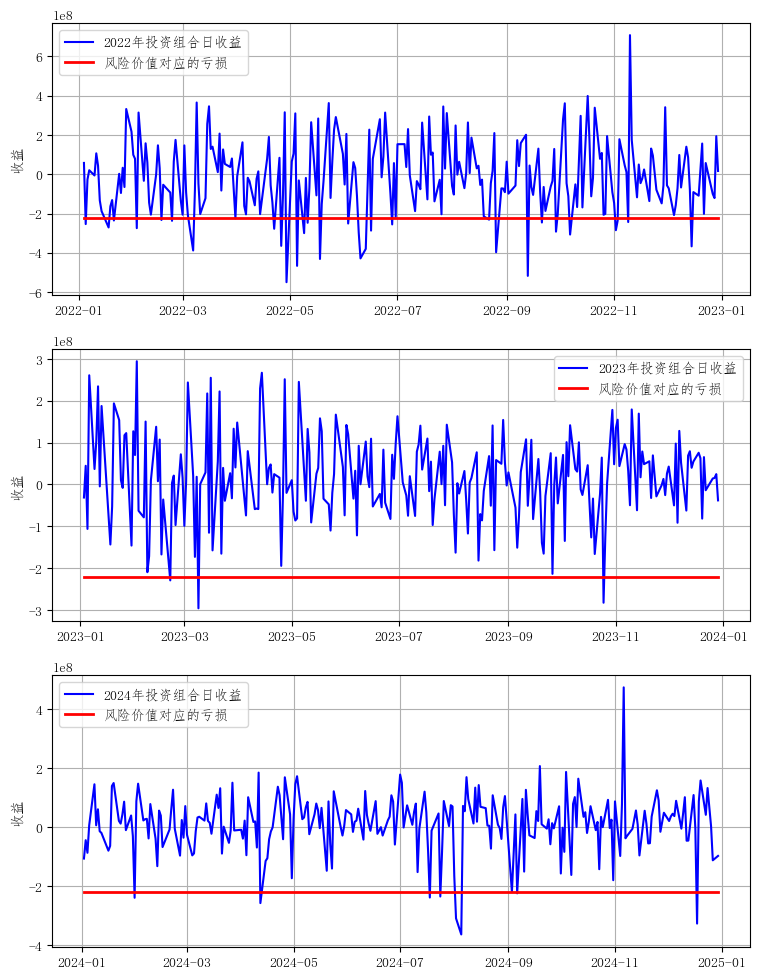

In [100]:
# 当投资组合日亏损金额触及红线时，就表明亏损金额大于风险价值，通过作图可以发现，2022年因为疫情和国际形势不稳定超过的天数最多
# 2023年和2024年较少
plt.figure(figsize=(9,12))
plt.subplot(3,1,1)
plt.plot(profit_2022, 'b-', label=u'2022年投资组合日收益')
plt.plot(VaR_2022_neg, 'r-', label=u'风险价值对应的亏损', lw=2.0)
plt.ylabel(u'收益')
plt.legend()
plt.grid()
plt.subplot(3,1,2)
plt.plot(profit_2023, 'b-', label=u'2023年投资组合日收益')
plt.plot(VaR_2023_neg, 'r-', label=u'风险价值对应的亏损', lw=2.0)
plt.ylabel(u'收益')
plt.legend()
plt.grid()
plt.subplot(3,1,3)
plt.plot(profit_2024, 'b-', label=u'2024年投资组合日收益')
plt.plot(VaR_2024_neg, 'r-', label=u'风险价值对应的亏损', lw=2.0)
plt.ylabel(u'收益')
plt.legend()
plt.grid()

In [101]:
days_2022 = len(profit_2022) #2022年计算的全部交易天数
days_2023 = len(profit_2023)
days_2024 = len(profit_2024)
print('2022年的全部交易天数', days_2022)
print('2023年的全部交易天数', days_2023)
print('2024年的全部交易天数', days_2024)

2022年的全部交易天数 250
2023年的全部交易天数 250
2024年的全部交易天数 251


In [102]:
daysexcept_2022 = len(profit_2022[profit_2022['投资组合的模拟日收益'] < -VaR95_1day_VCM])
daysexcept_2023 = len(profit_2023[profit_2023['投资组合的模拟日收益'] < -VaR95_1day_VCM])
daysexcept_2024 = len(profit_2024[profit_2024['投资组合的模拟日收益'] < -VaR95_1day_VCM])
print('2022年超过风险价值对应亏损的天数', daysexcept_2022)
print('2023年超过风险价值对应亏损的天数', daysexcept_2023)
print('2024年超过风险价值对应亏损的天数', daysexcept_2024)

2022年超过风险价值对应亏损的天数 31
2023年超过风险价值对应亏损的天数 3
2024年超过风险价值对应亏损的天数 8


In [103]:
# 通过分析发现2022年超过风险价值对应亏损的天数占全年交易天数的比例超过5%，2023年和2024年没有超过，默认该模型在这两年是可行的
ratio_2022 = daysexcept_2022/days_2022
ratio_2023 = daysexcept_2023/days_2023
ratio_2024 = daysexcept_2024/days_2024
print('2022年超过风险价值对应亏损天数占全年交易天数的比例', round(ratio_2022, 4))
print('2023年超过风险价值对应亏损天数占全年交易天数的比例', round(ratio_2023, 4))
print('2024年超过风险价值对应亏损天数占全年交易天数的比例', round(ratio_2024, 4))

2022年超过风险价值对应亏损天数占全年交易天数的比例 0.124
2023年超过风险价值对应亏损天数占全年交易天数的比例 0.012
2024年超过风险价值对应亏损天数占全年交易天数的比例 0.0319


### 2.6 压力测试

In [104]:
# 从上述的案例可知，22年由于疫情，市场波动性较大，所以我们这里简单的以2022年3月-2022年10月的数据作为压力期间，进行压力风险价值的测算
R_stress = R.loc['2022-03-01':'2022-10-31']
profit_stress = profit_past.loc['2022-03-01':'2022-10-31']

In [105]:
profit_zero = np.zeros_like(profit_stress)
profit_zero = pd.DataFrame(data=profit_zero, index=profit_stress.index)

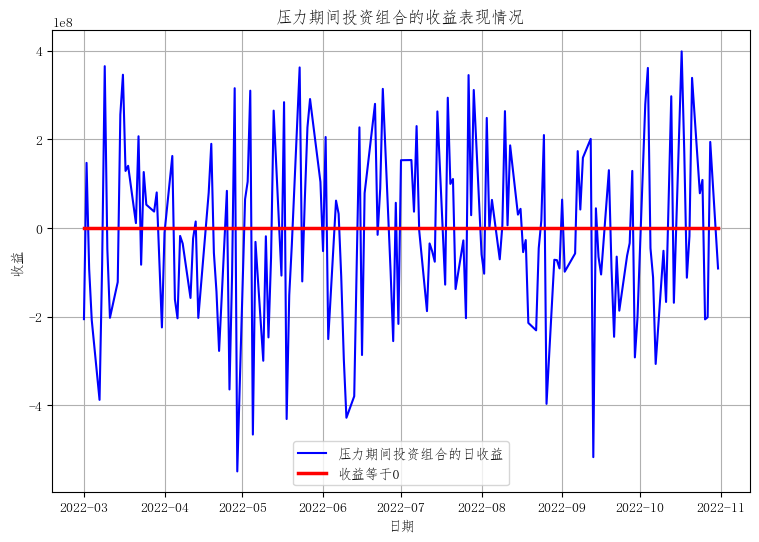

In [106]:
# 作图发现，压力期间的亏损天数大于盈利天数
plt.figure(figsize=(9,6))
plt.plot(profit_stress, 'b-', label=u'压力期间投资组合的日收益')
plt.plot(profit_zero, 'r-', label=u'收益等于0', lw=2.5)
plt.xlabel(u'日期')
plt.ylabel(u'收益')
plt.title('压力期间投资组合的收益表现情况')
plt.legend()
plt.grid()
plt.show()

In [107]:
# 压力测试，持有期为1天，置信水平为95%的风险价值
SVaR95_1day = np.abs(np.percentile(a=profit_stress, q=(1-X)*100))
SES95_1day = np.abs(profit_stress[profit_stress <= np.percentile
                      (profit_stress, q=(1-X)*100)].mean().values[0])

In [108]:
SVaR95_10day = np.sqrt(D) * SVaR95_1day
SES95_10day = np.sqrt(D) * SES95_1day
print('压力测试，持有期为10天，置信水平为95%的风险价值VaR', round(SVaR95_10day,2))
print('压力测试，持有期为10天，置信水平为95%的风险价值ES', round(SES95_10day,2))

压力测试，持有期为10天，置信水平为95%的风险价值VaR 1070318946.79
压力测试，持有期为10天，置信水平为95%的风险价值ES 1377516442.01


**测算结果汇总如下：**
**持有期为10天，置信水平为95%的风险价值测试（单位：亿元）**

| 计量指标 | 方差-协方差法 | 历史模拟法 | 蒙特卡罗（t分布） | 蒙特卡罗（正态分布） | 压力测试 |
|----------|----------------|--------------|----------------------|--------------------------|------------|
| **VaR**  | 6.974          | 7.330        | 10.368               | 9.112                   | 10.703     |
| **ES**   | 8.781          | 9.870        | 13.926               | 11.391                  | 13.775     |
